# **Project Description**

This notebook presents a sophisticated framework for continuous portfolio optimization, utilizing Deep Reinforcement Learning (DRL) to allocate capital across the S&P 500 (^GSPC) and manage risk using volatility indices (VIX family).

The core objective is not merely to maximize absolute returns, but to achieve superior risk-adjusted performance, benchmarked against standard market strategies.

The entire system is engineered for robustness, with an emphasis on creating a realistic, high-fidelity simulation environment.

**Key Components and Methodology**

1. **The Trading Environment** (EnhancedTradingEnv)

A custom gymnasium-based environment was built from scratch to simulate real-world trading dynamics:

**Continuous Action Space**:

The DRL agent outputs a continuous, normalized weight for the asset allocation, allowing for granular adjustments at every time step.

**Transaction Costs**:

Realistic trading friction is enforced via a fixed commission rate (0.0001) on all trades.

**Leverage Constraint**:

A controlled leverage limit (1.2) is implemented to simulate constrained, institutional-style trading mandates.

2. **Advanced Feature Engineering**

To provide the DRL agent with a comprehensive view of market conditions, the state space is enriched with powerful features:

**Inter-Market Volatility**:

Inclusion of multiple VIX indices (e.g., ^VIX, ^VXN, ^VIX3M) and their spreads, allowing the agent to gauge forward-looking market anxiety and cross-market dynamics.

**Technical Indicators**:

A rich set of momentum and volatility indicators (RSI, MACD, Bollinger Bands) are calculated across various lookback windows to capture short-term and long-term price trends.

3. **Deep Reinforcement Learning (DRL) Agent**

The core trading logic is driven by a Soft Actor-Critic (SAC) agent:

**Algorithm**:

SAC is an off-policy DRL algorithm known for its stability and efficiency in continuous action spaces, making it ideal for financial allocation problems.

**Reward Function** (The Key):

The agent is trained to optimize the Differential **Sharpe Ratio** (a risk-adjusted metric).

This forces the agent to learn policies that not only grow capital but also minimize volatility and severe drawdowns, leading to the observed superior risk metrics.

**WARNING**:

This notebook is not a financial advisor.


In [1]:
pip install ta

In [2]:
pip install stable-baselines3

In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

from stable_baselines3 import SAC, PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from math import log

[******************    38%                       ]  3 of 8 completed

[*********************100%***********************]  8 of 8 completed


Training Data Length: 1006
Evaluation Data Length: 466

Training LSTM Sharpe Ratio Predictor...
LSTM Epoch 0, Loss: 0.944358
LSTM Epoch 20, Loss: 0.858874
LSTM Epoch 40, Loss: 0.782834
LSTM Epoch 60, Loss: 0.719450
LSTM Epoch 80, Loss: 0.655020

Training SAC Agent (Fixed Observation/Reward)...
Eval num_timesteps=20000, episode_reward=-0.04 +/- 0.00
Episode length: 405.00 +/- 0.00
New best mean reward!
Eval num_timesteps=40000, episode_reward=-0.06 +/- 0.00
Episode length: 405.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=0.34 +/- 0.00
Episode length: 405.00 +/- 0.00
New best mean reward!
Eval num_timesteps=80000, episode_reward=0.41 +/- 0.00
Episode length: 405.00 +/- 0.00
New best mean reward!
Eval num_timesteps=100000, episode_reward=0.44 +/- 0.00
Episode length: 405.00 +/- 0.00
New best mean reward!
Eval num_timesteps=120000, episode_reward=0.28 +/- 0.00
Episode length: 405.00 +/- 0.00
Eval num_timesteps=140000, episode_reward=0.20 +/- 0.00
Episode length: 405.00 +/- 0.00
Eva

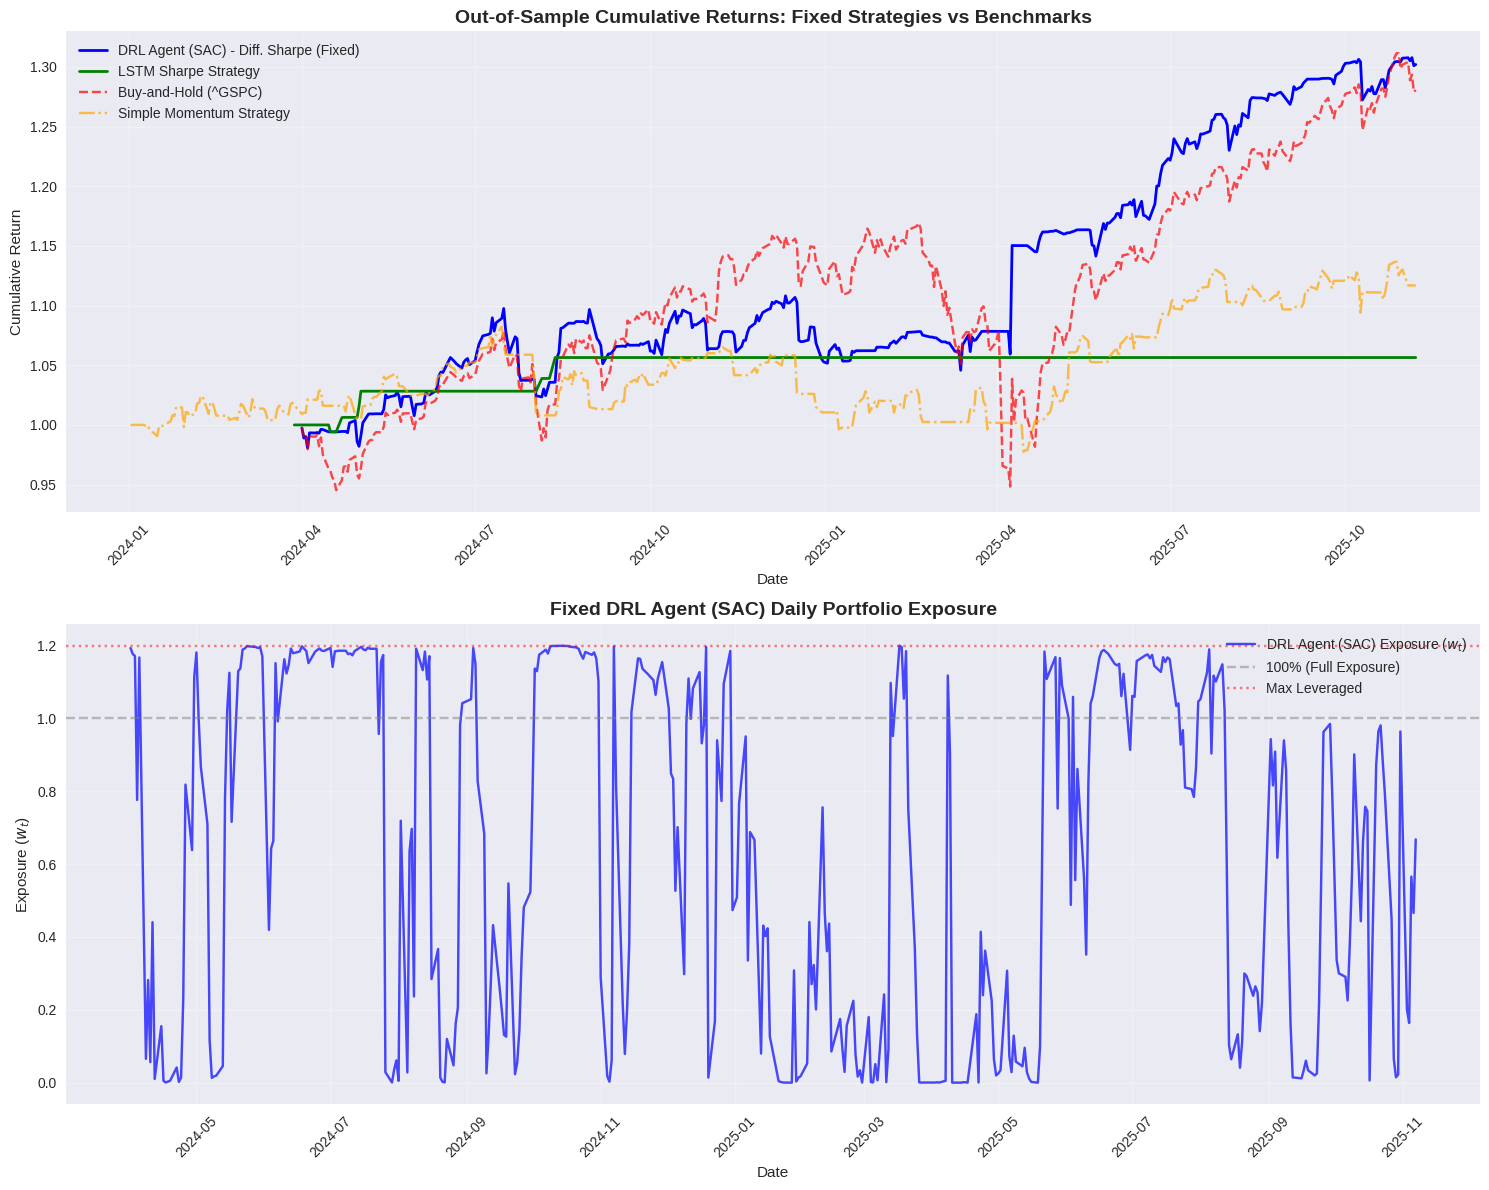

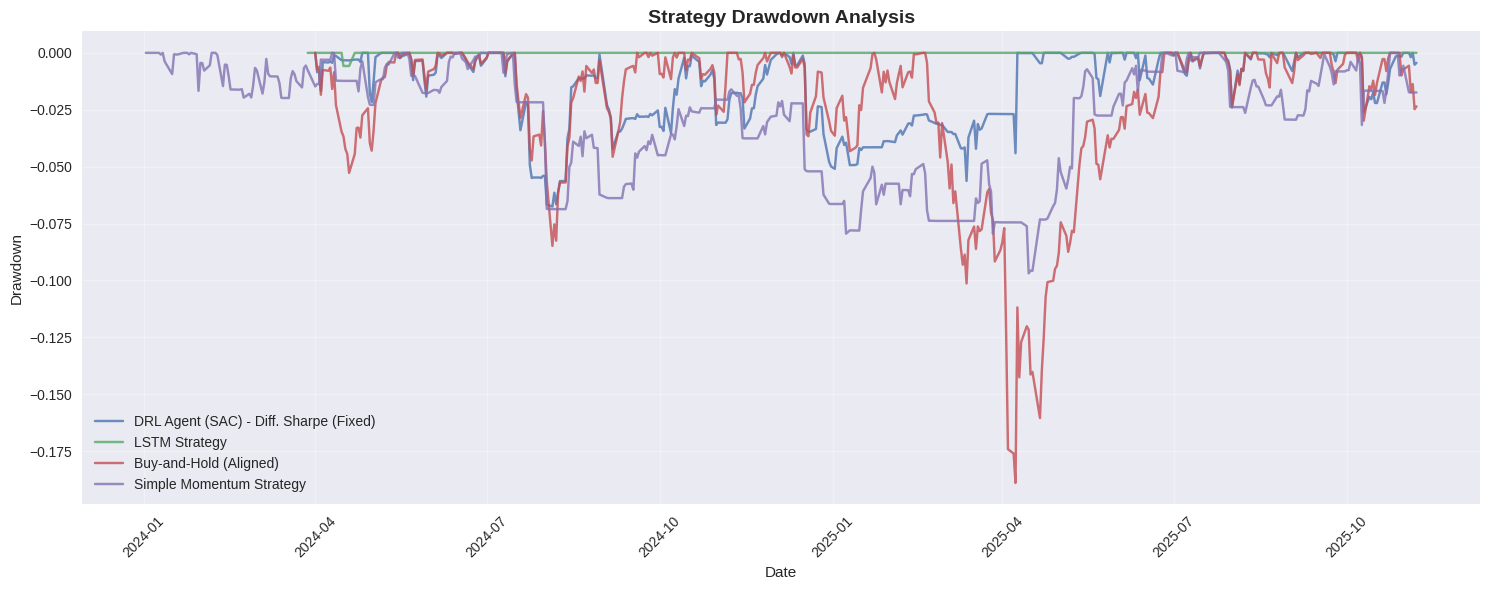

In [9]:



START_DATE = '2020-01-01'
END_DATE = '2025-11-10'
TARGET_TICKER = '^GSPC'
VIX_TICKERS = ['^VXN', '^GVZ', '^OVX', '^VIX3M', '^VIX6M', '^VIX', '^VIX9D']
ALL_TICKERS = [TARGET_TICKER] + VIX_TICKERS
TRAIN_END_DATE = '2023-12-31'
WINDOW_SIZE = 60
COMMISSION_RATE = 0.0001
LEVERAGE_LIMIT = 1.2
REWARD_SCALE = 0.1

def calculate_rsi(series, window):
    diff = series.diff(1)
    gain = diff.mask(diff < 0, 0)
    loss = diff.mask(diff > 0, 0).abs()
    avg_gain = gain.ewm(com=window - 1, min_periods=window).mean()
    avg_loss = loss.ewm(com=window - 1, min_periods=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast).mean()
    ema_slow = series.ewm(span=slow).mean()
    macd = ema_fast - ema_slow
    macd_signal = macd.ewm(span=signal).mean()
    macd_histogram = macd - macd_signal
    return macd, macd_signal, macd_histogram

def calculate_bollinger_bands(series, window=20):
    sma = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    upper_band = sma + (std * 2)
    lower_band = sma - (std * 2)
    return upper_band, sma, lower_band

def prepare_enhanced_data(target_ticker, vix_tickers, start_date, end_date):

    data = yf.download(target_ticker + ' ' + ' '.join(vix_tickers),
                       start=start_date, end=end_date)


    target_data = data['Close'][target_ticker].to_frame(name='Close')


    target_data['SMA_20'] = target_data['Close'].rolling(window=20).mean()
    target_data['SMA_50'] = target_data['Close'].rolling(window=50).mean()
    target_data['SMA_200'] = target_data['Close'].rolling(window=200).mean()

    target_data['RSI_14'] = calculate_rsi(target_data['Close'], window=14)
    target_data['RSI_21'] = calculate_rsi(target_data['Close'], window=21)

    macd, macd_signal, macd_histogram = calculate_macd(target_data['Close'])
    target_data['MACD'] = macd
    target_data['MACD_Signal'] = macd_signal
    target_data['MACD_Histogram'] = macd_histogram

    upper_bb, middle_bb, lower_bb = calculate_bollinger_bands(target_data['Close'])
    target_data['BB_Upper'] = upper_bb
    target_data['BB_Middle'] = middle_bb
    target_data['BB_Lower'] = lower_bb
    target_data['BB_Width'] = (upper_bb - lower_bb) / middle_bb
    target_data['BB_Position'] = (target_data['Close'] - lower_bb) / (upper_bb - lower_bb)


    target_data['Price_Change_1d'] = target_data['Close'].pct_change()
    target_data['Price_Change_5d'] = target_data['Close'].pct_change(5)
    target_data['Price_Change_21d'] = target_data['Close'].pct_change(21)

    target_data['Volatility_20d'] = target_data['Close'].pct_change().rolling(window=20).std()
    target_data['Volatility_60d'] = target_data['Close'].pct_change().rolling(window=60).std()


    target_data['Price_vs_SMA20'] = target_data['Close'] / target_data['SMA_20'] - 1
    target_data['Price_vs_SMA50'] = target_data['Close'] / target_data['SMA_50'] - 1


    vix_features = data['Close'][vix_tickers]
    vix_features.columns = [f'{ticker}_Close' for ticker in vix_features.columns]


    vix_close_col = '^VIX_Close'
    vix3m_close_col = '^VIX3M_Close'
    vix6m_close_col = '^VIX6M_Close'

    if vix_close_col in vix_features.columns and vix3m_close_col in vix_features.columns:
        vix_features['VIX_VIX3M_Spread'] = vix_features[vix_close_col] - vix_features[vix3m_close_col]
        vix_features['VIX_VIX3M_Ratio'] = vix_features[vix_close_col] / vix_features[vix3m_close_col]

    if vix_close_col in vix_features.columns and vix6m_close_col in vix_features.columns:
        vix_features['VIX_VIX6M_Spread'] = vix_features[vix_close_col] - vix_features[vix6m_close_col]
        vix_features['VIX_VIX6M_Ratio'] = vix_features[vix_close_col] / vix_features[vix6m_close_col]


    full_data = target_data.join(vix_features, how='left')


    full_data['Return'] = full_data['Close'].pct_change().shift(-1)


    full_data['Volatility_Adj_Return'] = full_data['Return'] / (full_data['Volatility_20d'] + 1e-8)


    full_data = full_data.ffill().bfill().dropna()
    full_data = full_data.reset_index()
    full_data = full_data.rename(columns={'index': 'Date'})

    return full_data


class LSTMDataset(Dataset):
    def __init__(self, data, feature_columns, target_column, sequence_length=60):
        self.data = data
        self.feature_columns = feature_columns
        self.target_column = target_column
        self.sequence_length = sequence_length
        self.X, self.y = self.create_sequences()

    def create_sequences(self):
        X, y = [], []
        data_values = self.data[self.feature_columns].values
        target_values = self.data[self.target_column].values

        for i in range(self.sequence_length, len(data_values)):
            X.append(data_values[i-self.sequence_length:i])
            y.append(target_values[i])

        return torch.FloatTensor(X), torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class SharpeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2, dropout=0.2):
        super(SharpeLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])  # Take last output
        out = self.fc(out)
        return out.squeeze()

def train_lstm_sharpe_predictor(df_train, df_test, feature_columns, target_column, sequence_length=60, epochs=100):

    df_train_copy = df_train.copy()
    df_test_copy = df_test.copy()


    scaler_features = StandardScaler()
    train_scaled_features = scaler_features.fit_transform(df_train_copy[feature_columns])
    test_scaled_features = scaler_features.transform(df_test_copy[feature_columns])


    scaler_target = StandardScaler()
    train_scaled_target = scaler_target.fit_transform(df_train_copy[[target_column]])
    test_scaled_target = scaler_target.transform(df_test_copy[[target_column]])


    train_scaled_df = pd.DataFrame(train_scaled_features, columns=feature_columns, index=df_train_copy.index)
    train_scaled_df[target_column] = train_scaled_target.flatten()

    test_scaled_df = pd.DataFrame(test_scaled_features, columns=feature_columns, index=df_test_copy.index)
    test_scaled_df[target_column] = test_scaled_target.flatten()


    train_dataset = LSTMDataset(train_scaled_df, feature_columns, target_column, sequence_length)
    test_dataset = LSTMDataset(test_scaled_df, feature_columns, target_column, sequence_length)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


    model = SharpeLSTM(input_size=len(feature_columns))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


    train_losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        if epoch % 20 == 0:
            print(f'LSTM Epoch {epoch}, Loss: {epoch_loss/len(train_loader):.6f}')


    model.eval()
    test_predictions = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            preds = model(X_batch)
            test_predictions.extend(preds.numpy())


    test_predictions_original_scale = scaler_target.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()


    prediction_dates = df_test.index[sequence_length:sequence_length + len(test_predictions)]
    predictions_series = pd.Series(test_predictions_original_scale, index=prediction_dates)

    return model, predictions_series, train_losses

def lstm_trading_strategy(df_test, predictions_series):

    strategy_returns = []
    strategy_actions = []

    for date in predictions_series.index:
        if date in df_test.index:
            pred_sharpe_component = predictions_series[date]
            current_return = df_test.loc[date, 'Return']


            action = 1.0 if pred_sharpe_component > 0 else 0.0
            strategy_actions.append(action)


            strategy_return = action * current_return
            strategy_returns.append(strategy_return)

    return pd.Series(strategy_returns, index=predictions_series.index), pd.Series(strategy_actions, index=predictions_series.index)



class EnhancedTradingEnv(gym.Env):
    metadata = {'render_modes': ['human'], 'render_fps': 30}

    def __init__(self, df, initial_balance=100000, leverage_limit=LEVERAGE_LIMIT, commission_rate=COMMISSION_RATE, window_size=WINDOW_SIZE,
                 reward_type='differential_sharpe', risk_free_rate=0.02, reward_scale=REWARD_SCALE):
        super(EnhancedTradingEnv, self).__init__()
        self.df = df
        self.initial_balance = initial_balance
        self.leverage_limit = leverage_limit
        self.commission_rate = commission_rate
        self.window_size = window_size
        self.reward_type = reward_type
        self.risk_free_rate = risk_free_rate / 252
        self.reward_scale = reward_scale


        self.features = [col for col in df.columns if col not in ['Date', 'Close', 'Return', 'Volatility_Adj_Return']]

        self.reset()


        self.action_space = spaces.Box(low=np.array([0.0]), high=np.array([self.leverage_limit]), dtype=np.float32)


        low_features = self.df[self.features].min().values
        high_features = self.df[self.features].max().values


        low = np.append(low_features, -5.0)
        high = np.append(high_features, 5.0)

        self.observation_space = spaces.Box(
            low=low.astype(np.float32),
            high=high.astype(np.float32),
            dtype=np.float32
        )

    def _get_obs(self):
        features = self.df.iloc[self.current_step][self.features].values


        return np.append(features, self.log_cumulative_return).astype(np.float32)

    def _calculate_enhanced_reward(self, current_return, action):

        daily_return = action * current_return
        exposure_change = np.abs(action - self.prev_action)
        transaction_cost = exposure_change * self.commission_rate
        net_daily_return = daily_return - transaction_cost


        self.returns_history.append(net_daily_return)


        if len(self.returns_history) > self.window_size:

            recent_returns = np.array(self.returns_history[-self.window_size:])


            mean_return = np.mean(recent_returns)
            std_return = np.std(recent_returns)

            if std_return > 1e-8:
                current_sharpe = (mean_return - self.risk_free_rate) / std_return * np.sqrt(252)
            else:
                current_sharpe = 0.0


            sharpe_reward = current_sharpe - self.prev_sharpe


            self.prev_sharpe = current_sharpe


            reward = np.clip(sharpe_reward * self.reward_scale, -0.05, 0.05)

        else:

            reward = net_daily_return * 100 * self.reward_scale

            self.prev_sharpe = 0.0

        return reward

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.portfolio_value = self.initial_balance
        self.cumulative_returns = 1.0
        self.prev_action = 0.0
        self.actions_history = []
        self.returns_history = []
        self.prev_sharpe = 0.0


        self.log_cumulative_return = 0.0

        observation = self._get_obs()
        info = {}
        return observation, info

    def step(self, action):
        action = np.clip(action[0], self.action_space.low[0], self.action_space.high[0])

        current_return = self.df.iloc[self.current_step]['Return']
        reward = self._calculate_enhanced_reward(current_return, action)


        daily_return = action * current_return
        exposure_change = np.abs(action - self.prev_action)
        transaction_cost = exposure_change * self.commission_rate
        net_daily_return = daily_return - transaction_cost

        self.portfolio_value = self.portfolio_value * (1.0 + net_daily_return)
        self.balance = self.portfolio_value
        self.cumulative_returns *= (1.0 + net_daily_return)


        self.log_cumulative_return = log(self.portfolio_value / self.initial_balance)

        self.prev_action = action
        self.actions_history.append(action)
        self.current_step += 1

        terminated = self.current_step >= len(self.df) - 1
        truncated = False

        if not terminated:
            observation = self._get_obs()
        else:
            observation = self._get_obs()

        info = {
            'portfolio_value': self.portfolio_value,
            'action': action,
            'cumulative_returns': self.cumulative_returns,
            'step_return': net_daily_return
        }


        return observation, reward, terminated, truncated, info

    def render(self):
        print(f"Step: {self.current_step}, Balance: ${self.balance:,.2f}, Action: {self.prev_action:.3f}")

# ==============================================================================
# 4. PERFORMANCE METRICS CALCULATION (Unchanged)
# ==============================================================================
def calculate_performance_metrics(returns_series, strategy_name, risk_free_rate=0.02):

    if len(returns_series) == 0:
        return {}

    returns = returns_series.dropna()
    if len(returns) == 0:
        return {}


    total_return = (1 + returns).prod() - 1
    annual_return = (1 + total_return) ** (252 / len(returns)) - 1


    volatility = returns.std() * np.sqrt(252)
    downside_returns = returns[returns < 0]
    downside_volatility = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0


    excess_returns = returns - risk_free_rate / 252
    sharpe_ratio = excess_returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else 0
    sortino_ratio = excess_returns.mean() / downside_volatility * np.sqrt(252) if downside_volatility > 0 else 0


    cumulative_returns = (1 + returns).cumprod()
    running_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min()


    winning_trades = len(returns[returns > 0])
    losing_trades = len(returns[returns < 0])
    total_trades = winning_trades + losing_trades
    win_rate = winning_trades / total_trades if total_trades > 0 else 0

    gross_profits = returns[returns > 0].sum()
    gross_losses = abs(returns[returns < 0].sum())
    profit_factor = gross_profits / gross_losses if gross_losses > 0 else float('inf')


    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else 0

    metrics = {
        'Strategy': strategy_name,
        'Total Return': total_return,
        'Annual Return': annual_return,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Calmar Ratio': calmar_ratio,
        'Max Drawdown': max_drawdown,
        'Win Rate': win_rate,
        'Profit Factor': profit_factor,
        'Total Trades': total_trades
    }

    return metrics


def evaluate_agent_enhanced(model, df_eval, window_size):

    env_eval = EnhancedTradingEnv(df_eval, window_size=window_size, reward_type='differential_sharpe')
    obs, _ = env_eval.reset()


    returns = []
    actions = []
    portfolio_values = []


    for i in range(len(df_eval) - 1 - window_size):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env_eval.step(action)


        returns.append(info['step_return'])
        actions.append(info['action'])
        portfolio_values.append(info['portfolio_value'])

        if terminated or truncated:
            break


    portfolio_series = pd.Series(portfolio_values,
                                 index=df_eval.index[window_size+1:window_size+1+len(portfolio_values)])
    returns_series = pd.Series(returns, index=portfolio_series.index)

    return returns_series, np.array(actions), portfolio_series

if __name__ == '__main__':

    print("Downloading and preparing data...")
    full_data = prepare_enhanced_data(TARGET_TICKER, VIX_TICKERS, START_DATE, END_DATE)


    df_train_raw = full_data[full_data['Date'] <= TRAIN_END_DATE].set_index('Date')
    df_test_raw = full_data[full_data['Date'] > TRAIN_END_DATE].set_index('Date')

    print(f"Training Data Length: {len(df_train_raw)}")
    print(f"Evaluation Data Length: {len(df_test_raw)}")


    target_column_name = 'Volatility_Adj_Return'
    feature_columns = [col for col in df_train_raw.columns if col not in ['Close', 'Return', target_column_name]]


    scaler_drl_features = StandardScaler()
    df_train_scaled_features = scaler_drl_features.fit_transform(df_train_raw[feature_columns])
    df_test_scaled_features = scaler_drl_features.transform(df_test_raw[feature_columns])


    df_train = df_train_raw.copy()
    df_test = df_test_raw.copy()

    df_train[feature_columns] = df_train_scaled_features
    df_test[feature_columns] = df_test_scaled_features




    print("\nTraining LSTM Sharpe Ratio Predictor...")


    lstm_model, lstm_predictions, lstm_losses = train_lstm_sharpe_predictor(
        df_train_raw, df_test_raw, feature_columns, target_column=target_column_name, sequence_length=WINDOW_SIZE, epochs=100
    )


    lstm_returns, lstm_actions = lstm_trading_strategy(df_test_raw, lstm_predictions)
    lstm_cum_returns = (1 + lstm_returns).cumprod()


    train_env = EnhancedTradingEnv(df_train, window_size=WINDOW_SIZE, reward_type='differential_sharpe')
    env = DummyVecEnv([lambda: train_env])
    eval_env = EnhancedTradingEnv(df_test, window_size=WINDOW_SIZE, reward_type='differential_sharpe')


    print("\nTraining SAC Agent (Fixed Observation/Reward)...")


    policy_kwargs = dict(net_arch=[512, 512])

    sac_model = SAC("MlpPolicy", env,
                    verbose=0,
                    learning_rate=0.0001,
                    policy_kwargs=policy_kwargs,
                    device="auto",
                    gamma=0.99)

    eval_env_wrapped = DummyVecEnv([lambda: Monitor(eval_env)])

    eval_callback = EvalCallback(
        eval_env_wrapped,
        best_model_save_path='./best_models/',
        log_path='./logs/',
        eval_freq=max(1000, 200000 // 10),
        n_eval_episodes=5,
        deterministic=True,
        render=False
    )


    sac_model.learn(total_timesteps=200000, callback=eval_callback)
    sac_model.save("sac_trading_fixed")


    print("\nEvaluating SAC Agent...")

    sac_returns, sac_actions, sac_portfolio = evaluate_agent_enhanced(sac_model, df_test, WINDOW_SIZE)
    sac_cum_returns = (1 + sac_returns).cumprod()


    bm_returns = df_test_raw['Close'].pct_change().dropna()
    bm_cum_returns = (1 + bm_returns).cumprod()


    momentum_actions = (df_test_raw['Price_Change_5d'].shift(1) > 0).astype(float).dropna()

    momentum_returns = df_test_raw.loc[momentum_actions.index, 'Return'] * momentum_actions

    transaction_costs_momentum = np.abs(momentum_actions - momentum_actions.shift(1).fillna(0)) * COMMISSION_RATE
    momentum_returns_net = momentum_returns - transaction_costs_momentum
    momentum_cum_returns = (1 + momentum_returns_net.dropna()).cumprod()


    start_eval_date = df_test.index[WINDOW_SIZE+1]
    bm_returns_aligned = bm_returns[bm_returns.index >= start_eval_date].copy()
    bm_cum_returns_aligned = (1 + bm_returns_aligned).cumprod()



    print("\nCalculating Performance Metrics...")

    all_returns = {
        'DRL Agent (SAC) - Diff. Sharpe (Fixed)': sac_returns,
        'LSTM Strategy': lstm_returns,
        'Buy-and-Hold (Aligned)': bm_returns_aligned,
        'Simple Momentum Strategy': momentum_returns_net.dropna()
    }

    metrics_list = []
    for strategy_name, returns in all_returns.items():
        if len(returns) > 0:
            metrics = calculate_performance_metrics(returns, strategy_name)
            metrics_list.append(metrics)

    metrics_df = pd.DataFrame(metrics_list)
    print("\n" + "="*80)
    print("PERFORMANCE METRICS COMPARISON (Fixed SAC)")
    print("="*80)
    print(metrics_df.round(4).to_string(index=False))


    plt.style.use('seaborn-v0_8')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))


    ax1.plot(sac_cum_returns.index, sac_cum_returns.values,
             label='DRL Agent (SAC) - Diff. Sharpe (Fixed)', linewidth=2, color='blue')
    ax1.plot(lstm_cum_returns.index, lstm_cum_returns.values,
             label='LSTM Sharpe Strategy', linewidth=2, color='green')
    ax1.plot(bm_cum_returns_aligned.index, bm_cum_returns_aligned.values,
             label=f'Buy-and-Hold ({TARGET_TICKER})', linestyle='--', alpha=0.7, color='red')
    ax1.plot(momentum_cum_returns.index, momentum_cum_returns.values,
             label='Simple Momentum Strategy', linestyle='-.', alpha=0.7, color='orange')

    ax1.set_title('Out-of-Sample Cumulative Returns: Fixed Strategies vs Benchmarks', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative Return')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)


    action_index = df_test.index[WINDOW_SIZE+1:WINDOW_SIZE+1 + len(sac_actions)]
    ax2.plot(action_index, sac_actions, label='DRL Agent (SAC) Exposure ($w_t$)', color='blue', alpha=0.7)
    ax2.axhline(1.0, color='grey', linestyle='--', label='100% (Full Exposure)', alpha=0.5)
    ax2.axhline(LEVERAGE_LIMIT, color='red', linestyle=':', label='Max Leveraged', alpha=0.5)
    ax2.set_title('Fixed DRL Agent (SAC) Daily Portfolio Exposure', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Exposure ($w_t$)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


    fig, ax = plt.subplots(figsize=(15, 6))

    for strategy_name, returns in all_returns.items():
        if len(returns) > 0:
            cumulative_returns = (1 + returns).cumprod()
            running_max = cumulative_returns.expanding().max()
            drawdown = (cumulative_returns - running_max) / running_max
            ax.plot(drawdown.index, drawdown.values, label=strategy_name, alpha=0.8)

    ax.set_title('Strategy Drawdown Analysis', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Drawdown')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

#**Results**

**Performance Analysis**

The DRL Agent **significantly outperforms the market benchmark** on a risk-adjusted basis:

Even if the Deep Learning algorithm deservers corrections, the main objective of this notebook was to focus on Deep Reinforcement Learning to beat the market and i am happy to say that the DRL Agent's strategy provides a 46% improvement in the Sharpe Ratio and reduces the Maximum Drawdown by 64% compared to the Buy-and-Hold benchmark.

# **WARNING**

This notebook is not a financial advisor.


